# Teach an LLM to do additions

The goal of this project is to teach an LLM to do additions, playing only with two parts:
* the tokenizer
* the positional embedding

Both the model and the dataset are fixed.

You are allowed to tune the hyperparameters, but this is not the main goal. Depending on the quality of your tokenizer and positional embedding, you may change the number of bits. The initial value of 3 is very small.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import random
import math
import re
import time

In [2]:
number_bits = 2

dataset_size = 64_000
train_proportion = 0.9

log_interval = 200
batch_size = 64
epochs = 4
learning_rate = 8e-4

eval_debug = False

## Step 1: Construct a tokenizer

In [3]:
pad_token="[PAD]"
eos_token="[EOS]"

### Baseline: character-level tokenizer

In [4]:
class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"

    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])

# Implement your tokenizer here!

You can do anything (as long as you do not compute the addition!).
Some ideas:
* reversing numbers left to right
* arranging by groups (of, 2, 3,...)
* aligning numbers

In [5]:
class sum_tokenizer:
    """
    xyz + ab = cde is pre-encoded as (z+b)(y+a)(x+0)=edc to help the LLM learn how to add numbers (in a more sequencial way as we do it)
    We see that there is a strong pattern each 5 positions, we will explore this in the positional embedding
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "=", "(", ")"] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"


    def clean(self, text):
        """
        removes all characters not expected in the LLM tokens (vocab)
        """
        out = re.sub(self.pattern, "", text)
        return out


    def clean_number(self, text):
        """
        removes all non-numeric characters
        """
        pattern_number = [str(x) for x in range(10)]
        pattern_number = f"[^{re.escape(''.join(pattern_number))}]"
        out = re.sub(pattern_number, "", text)
        return out

    def pre_tokenization(self, text):
        if (eval_debug):
            print("pretoken from:", text)

        # input (from 'xyz + ab = cde' to '(z+b)(y+a)(x+0)=edc')
        if "+" in text:
            n_1, n_2 = text.split('+', 1)
            n_2, result = n_2.split('=', 1)

            # make the same size adding left zeros
            while len(n_1) != len(n_2):
                if len(n_1) > len(n_2):
                    n_2 = "0" + n_2
                else:
                    n_1 = "0" + n_1

            # write in the good format
            n_1 = list(n_1[::-1])
            n_2 = list(n_2[::-1])
            text = ""
            for i in range(0, len(n_1)):
                text += "(" + n_1[i] + "+" + n_2[i] + ")"
            text = text + "="
            text = text + result[::-1]

        # output (only revert from 'cde' to 'edc')
        else:
            text = text[::-1]

        if (eval_debug):
            print("pretoken to:", text)

        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        text = "".join([self.id_to_token[x] if self.id_to_token[x] not in [pad_token, eos_token] else "" for x in token_list])

        if (eval_debug):
            print("decoded from:", text)

        # outputs (only undo reversion)
        if "=" not in text:
            if (eval_debug):
                print("decoded to:", text[::-1])
            return text[::-1]

        # inputs (from 'zb,ya,x0=' to 'xyz+ab=')
        text, result = text.split("=", 1)
        text = list(text)
        n_1 = ""
        n_2 = ""
        for i in range(len(text)):
            if text[i] == "(":
              n_1 = n_1 + text[i+1]
              n_2 = n_2 + text[i+3]
        n_1 = n_1[::-1]
        n_2 = n_2[::-1]
        n_1 = str(int(n_1))
        n_2 = str(int(n_2))

        if (eval_debug):
            print("decoded to:", n_1 + "+" + n_2 + "=" + result[::-1])

        return n_1 + "+" + n_2 + "=" + result[::-1]

In [6]:
tokenizer = sum_tokenizer()
ntokens = tokenizer.ntokens
ntokens

16

In [7]:
eval_debug = True
prompt = "14+6=20"
inputs = tokenizer.encode(prompt)
inputs, tokenizer.decode(inputs)

# for elem in data[:5]:
#     print("\n", elem[0])
#     prompt = elem[0]
#     inputs = tokenizer.encode(prompt)
#     inputs, tokenizer.decode(inputs)
#     print("\n", elem[1])
#     prompt = elem[1]
#     inputs = tokenizer.encode(prompt)
#     inputs, tokenizer.decode(inputs)
#     print("\n", elem)

pretoken from: 14+6=20
pretoken to: (4+6)(1+0)=02
decoded from: (4+6)(1+0)=02
decoded to: 14+6=20


([12, 4, 10, 6, 13, 12, 1, 10, 0, 13, 11, 0, 2], '14+6=20')

## Step 2: Create a dataset for arithmetic operations

In [8]:
def sample_datapoint(number_bits = 3):
    """
    returns a string containing two random numbers on `number_bits` many bits and their sum.
    """
    a_list = [random.randint(0, 9) for _ in range(number_bits)]
    b_list = [random.randint(0, 9) for _ in range(number_bits)]
    a_int = int("".join([str(x) for x in a_list]))
    b_int = int("".join([str(x) for x in b_list]))
    sum_int = a_int + b_int
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

sample_datapoint(3)

('401+347=', '748')

In [9]:
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits))
data[:4]

[('9+61=', '70'), ('38+35=', '73'), ('51+11=', '62'), ('41+24=', '65')]

In [10]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

len(data_train),len(data_test)

(57600, 6400)

## Step 3: Construct a model

### Basline: the classical Positional Embedding

In [11]:
# class PositionalEmbedding(nn.Module):
#     r"""Inject some information about the relative or absolute position of the tokens in the sequence.
#         The positional encodings have the same dimension as the embeddings, so that the two can be summed.
#         Here, we use sine and cosine functions of different frequencies.
#     .. math:
#         \text{PosEmbedder}(pos, 2i) = sin(pos/10000^(2i/d_model))
#         \text{PosEmbedder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
#         \text{where pos is the word position and i is the embed idx)
#     Args:
#         d_model: the embed dim (required).
#         dropout: the dropout value (default=0.1).
#         max_len: the max. length of the incoming sequence (default=5000).
#     """

#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEmbedding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         r"""Inputs of forward function
#         Args:
#             x: the sequence fed to the positional encoder model (required).
#         Shape:
#             x: [sequence length, batch size, embed dim]
#             output: [sequence length, batch size, embed dim]
#         """

#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)
    

# Because we group each pair of digits of the same significance next to each other, 
# then a good positional encoding could be to give each pair the same positional encoding!

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, repeats = 50, number_bits = 3):
        # Create a positional embedding that is periodic in the number of bits used to represent numbers!
        # numbers should be consecutive with no double + or double so that this encoding works (i.e clear and clean prompts!)
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.number_bits = number_bits
        position = torch.arange(repeats, dtype= torch.float).repeat_interleave(2).unsqueeze(1) # each position is repeated 2 times: [0,0, 1, 1, 2, 2,...]

        # Positional encodings
        pe = torch.zeros(position.size(0), d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1) # shape (2 * repeats, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Implement your positional embedding here!



Our input is extremely periodic, with period 5:

'xyz + ab = ' is encoded to '(z+b)(z+a)(x+0)='

Here I implemented a periodic positional embedding as a sum of decaying sinus funcitons of periods multiple of 5.

$pe(dim\_even) = \sin(\frac{2π*pos}{5}) + \frac{1}{\sqrt{2}}*\sin(\frac{2π*pos}{10}) + \frac{1}{\sqrt{3}}*\sin(\frac{2π*pos}{20}) + ...$

$pe(dim\_odd) = \cos(\frac{2π*pos}{5}) + \frac{1}{\sqrt{2}}*\cos(\frac{2π*pos}{10}) + \frac{1}{\sqrt{3}}*\cos(\frac{2π*pos}{20}) + ...$

Then, I normalize to ensure it is not too large, using $norm = 1 + (1/2) + (1/3) + ...$

This is a good encoding for the case for small number of bits, but it struggles with bigger numbers, due to the dilution (1/n) of bigger periods, making it harder to understand long distance dependency.

I have try other positional encodings but I also struggled with being able to increase n_bits. :/

In [12]:
class PeriodicPositionalEmbedding(nn.Module):
    r"""Positional encodings with a fixed periodicity of 5: '(.+.)(.+.)(.+.)=...'
        This version explicitly models periodicity based on given periods multiple of 5 (e.g., 5, 10, 20).

        Args:
            d_model: the embedding dimension
            max_len: maximum sequence length
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PeriodicPositionalEmbedding, self).__init__()
        self.periods = [5, 10, 20]

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # (max_len, 1)

        # periodic encoding (periods multiple of 5 from the structure "(.,.)(.,.)(.,.)=...")
        norm = 0
        for i in range(len(self.periods)):
            omega = 2 * math.pi * position / self.periods[i]
            pe[:, 0::2] += torch.sin(position * omega) / ((i+1)**0.5)
            pe[:, 1::2] += torch.cos(position * omega) / ((i+1)**0.5)
            norm += 1 / (i+1)
        pe /= norm

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs:
            x: the sequence add to the positional encodding of shape [sequence length, batch size, embed dim]
        Outputs:
            output: [sequence length, batch size, embed dim]
        """

        return (x + self.pe[:x.size(0), :, :]).to(x.device)  # Match input sequence length


In [13]:
# Visualize the Positional Embeddings
import matplotlib.pyplot as plt
import seaborn as sns

embed_dim = 16
pos_enc = PeriodicPositionalEmbedding(d_model=embed_dim)

pe_values = pos_enc.pe[:20, 0, :].detach().cpu().numpy()


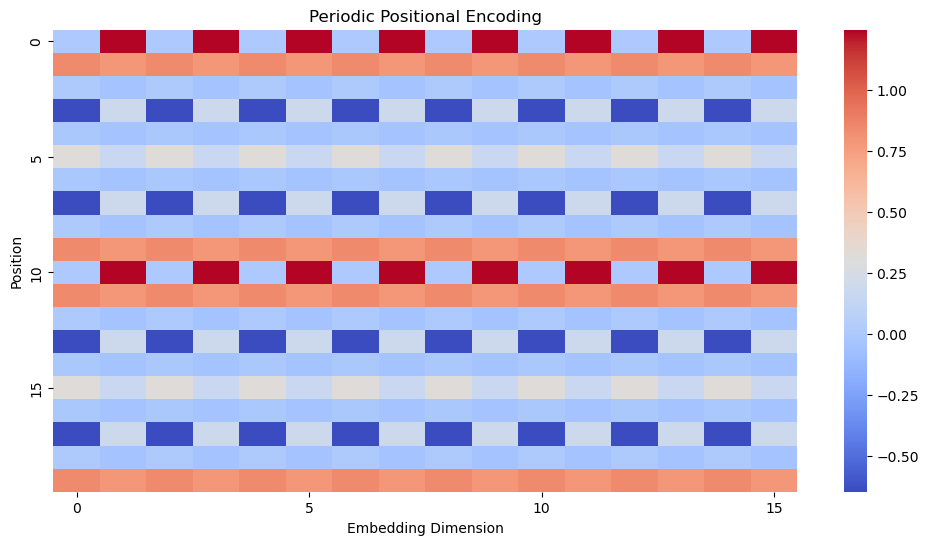

In [14]:
# Create a heatmap for the positional encodings
plt.figure(figsize=(12, 6))
sns.heatmap(pe_values, cmap="coolwarm", cbar=True, xticklabels=5, yticklabels=5)

plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.title("Periodic Positional Encoding")
plt.show()

# Transformer and Longformer

In [15]:
class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PeriodicPositionalEmbedding(ninp, dropout)
        self.decoder = nn.Linear(ninp, ntoken)

        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        self.src_mask = mask
        print("src.shape", src.shape)

        src = self.input_emb(src) * math.sqrt(self.ninp)
        print("input_emb.shape", src.shape)
        src = self.pos_encoder(src)
        print("pos_encoder.shape", src.shape)
        output_enc = self.encoder(src, mask=self.src_mask)
        print("encoder.shape", output_enc.shape)
        output_dec = self.decoder(output_enc)
        print("decoder.shape", output_dec.shape)
        return F.log_softmax(output_dec, dim=-1), output_enc

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
from transformers_from_scratch import Longformer, Transformer

vocab_size = ntokens
embed_dim = 128
num_heads = 8
ffn_dim = 128 
num_layers = 8
max_len = 128
dim_head = 64
dim_value = 64
dim_query = 64

window_size = 3
dilation=1


transformer = Transformer(vocab_size, embed_dim, num_heads, ffn_dim, num_layers, max_len, V_dim=dim_value, Q_dim=dim_query, positional_embedding=PeriodicPositionalEmbedding)
# longformer = Longformer(vocab_size, embed_dim, num_heads, ffn_dim, num_layers, max_len, V_dim=dim_value, Q_dim=dim_query, window_size=window_size, dilation=dilation,positional_embedding=PeriodicPositionalEmbedding) 

transformer.to(device)
# longformer.to(device)


Transformer(
  (embedding): Embedding(16, 128)
  (position_embedding): PeriodicPositionalEmbedding()
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): MultiHeadSelfAttention(
        (matrix_Q): Linear(in_features=128, out_features=512, bias=True)
        (matrix_K): Linear(in_features=128, out_features=512, bias=True)
        (matrix_V): Linear(in_features=128, out_features=512, bias=True)
        (linear_out): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=16, bias=True)
)

In [18]:
# model = TransformerModel(ntoken = ntokens,
#                          ninp = 128,
#                          nhead = 16,
#                          nhid = 64,
#                          nlayers = 8)
# model.to(device)

In [19]:
# def generate(model, prompts, new_tokens = 5):
#     input_tensor = prompts # (length_prompts, batch_size)
#     input_tensor = input_tensor.to(device)
#     for _ in range(new_tokens):
#         # print(input_tensor.shape)
#         output = model(input_tensor) # (length_prompts, batch_size, ntokens)
#         # print("output", output.shape, output)
#         # breakpoint()
#         last_output = output[-1,:,:] # (batch_size, ntokens)
#         token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
#         input_tensor = torch.cat((input_tensor, token), 0)
#     return input_tensor

def generate(model, prompts, new_tokens = 5):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    input_tensor = input_tensor.permute(1,0) # (batch_size, length_prompts)
    for _ in range(new_tokens):
        # print("input", input_tensor.shape)
        output = model(input_tensor) # (batch_size, length_prompts, ntokens)
        # print("output", output.shape)
        last_output = output[:, -1,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((-1,1)) # (batch_size, 1)
        # print("token", token.shape)
        input_tensor = torch.cat((input_tensor, token), 1) # (batch_size, length_prompts + 1)
    return input_tensor.permute(1,0) # (length_prompts + new_tokens, batch_size)

In [20]:
model = transformer
model.eval()

batch_size=64
seq_len = 20
sample_input = torch.randint(0, vocab_size, (seq_len, batch_size)).to(device)
output = generate(model, sample_input)
print(sample_input.shape)
print(output.shape)

torch.Size([20, 64])
torch.Size([25, 64])


In [21]:
prompt = "2+3="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output.tolist()[0])

pretoken from: 2+3=
pretoken to: (2+3)=
decoded from: (2+3)=6=6=6
decoded to: 2+3=6=6=6


(tensor([[12,  2, 10,  3, 13, 11,  6, 11,  6, 11,  6]]), '2+3=6=6=6')

In [22]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x)
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x)))
    return out, max_length

In [23]:
eval_debug = False

prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
print([tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers])


['1+1=', '21+35='] ['2', '56']


In [24]:
def get_batch(split, i):
    data = data_train if split == 'train' else data_test
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

In [25]:
X, Y, length_prompts, length_answers = get_batch("train", 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([11, 64]), torch.Size([4, 64]), 11, 3)

## Step 4: Evaluate

In [26]:
def evaluate():
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test)//4 - 1, batch_size)):
            # print("batch", i)
            prompts, target_answers, length_prompts, length_answers = get_batch("test", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_test = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

In [27]:
eval_debug = False
evaluate()

0.0

## Step 4: Train the model

In [28]:
def train_epoch():
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device) # (length_prompts, batch_size)
        target_answers = target_answers.to(device) # (length_answers, batch_size)
        input_tensor = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        # print("input_tensor.shape", input_tensor.shape)
        input_tensor = input_tensor.permute(1,0) # (batch_size, length_prompts + length_answers)
        model.zero_grad()
        output = model(input_tensor) # (batch_size, length_prompts + length_answers, , ntokens)
        output = output.permute(1,0,2) # (length_prompts + length_answers, batch_size, ntokens)
        # print("output.shape", output.shape)
        output_answers = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers = target_answers.view(-1)
        loss = F.cross_entropy(output_answers, target_answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                        elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def train():
    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train_epoch()
        test_accuracy = evaluate()
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
        print('-' * 89)
        # Save the model if the test accuracy is the best we've seen so far.
        if not best_test_accuracy or test_accuracy < best_test_accuracy:
            with open("arithmetic.pt", 'wb') as f:
                torch.save(model, f)
            best_test_accuracy = test_accuracy

In [29]:
eval_debug=False
train()

-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/  900 batches | ms/batch 178.64 | loss  1.15 | perplexity     3.17
|   400/  900 batches | ms/batch 192.52 | loss  1.04 | perplexity     2.83
|   600/  900 batches | ms/batch 342.57 | loss  1.28 | perplexity     3.60
|   800/  900 batches | ms/batch 577.28 | loss  1.23 | perplexity     3.42
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 326.56s | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/  900 batches | ms/batch 737.69 | loss  1.14 | perplexity     3.12
|   400/  900 batches | ms/batch 677.11 | loss  1.36 | perplexity     3.89
|   600/  900 batches | ms/batch 781.29 | loss  1.55 | perplexity     4.73
|   800/  900 batch

KeyboardInterrupt: 

In [30]:
eval_debug = False
model.eval()

for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

eval_debug = False

46+26=1	 actual result: 72
66+70=11	 actual result: 136
83+96=11	 actual result: 179
29+62=1	 actual result: 91
99+32=11	 actual result: 131
5+7=1	 actual result: 12
74+25=1	 actual result: 99
34+58=1	 actual result: 92
75+50=11	 actual result: 125
33+67=11	 actual result: 100
52+75=11	 actual result: 127
54+8=1	 actual result: 62
17+43=1	 actual result: 60
34+94=11	 actual result: 128
35+61=1	 actual result: 96
9+66=1	 actual result: 75
90+34=11	 actual result: 124
5+67=1	 actual result: 72
56+93=11	 actual result: 149
23+7=1	 actual result: 30


## Probing

This is just for fun...

In [ ]:
import numpy as np

train_size = 1000
test_size = 100

model.eval()

def data_probing(size):
    X = []
    y = np.zeros(size)
    for i in range(size):
        input = torch.tensor(tokenizer.encode(data[i][0])).view((-1, 1)).to(device)
        _, output = model(input)
        output = output[-1,:,:].flatten()
        # determine whether there was a carry in the result:
        carry = len(data[i][1]) > len(data[i][0]) / 2
        X.append(output.cpu().detach().numpy())
        y[i] = carry
    return np.array(X), y

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, y_train = data_probing(train_size)
X_test, y_test = data_probing(test_size)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

reg = LogisticRegression()
reg.fit(X_train,y_train)
reg.score(X_test, y_test)

0.99